# Multivariate Forecasting LSTM - 03.02 (OWN)
> Predicting a single point in the future
### Overview
* [Functionality](#Functionality)
* [Data - Factors and pairs](#Data---Factors-and-pairs)
    * [Valuta](#Valuta)
    * [Pairs](#Pairs)
    * [Factors](#Factors)
* [Preparing data](#Preparing-data)
    * [Normalizing](#Normalizing)
    * [Adding Features](#Adding-Features)
    * [Splitting](#Splitting)
* [Training dataset](#Training-dataset)
* [Validation dataset](#Validation-dataset)
* [Training](#Training)
    * [Model Architecture](#Model-Architecture)
    * [Callbacks and compiling](#Callbacks-and-compiling)
* [Prediction](#Prediction)

In [31]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import yfinance as yf

### Variables

split_fraction = 0.715
learning_rate = 0.001
past = 100
future = 2

START = '2013-01-01'
END = '2022-01-01'

days_to_pred = 5
tt_split = 0.7

### Indices

In [1]:
indices = pd.read_excel('MASTER_A.xlsx',
                        sheet_name = 'Indices2',
                        usecols=['Date', 'OSEBX', 'S&P 500', 'NYSE', 'FTSE 100',
                                 'MSCI CANADA','MSCI AUSTRALIA', 'CAC 40',
                                 'HANG SENG', 'TOPIX',
                                 ],
                        index_col = 'Date')
indices = indices[1:]
indices_returns = indices.pct_change()[1:]
indices_returns.index = indices_returns.index.astype(str) 
indices_returns.head()

<IPython.core.display.Javascript object>

,OSEBX,S&P 500,NYSE,FTSE 100,MSCI CANADA,MSCI AUSTRALIA,CAC 40,HANG SENG,TOPIX
Date,,,,,,,,,
2012-03-02,0.001704,-0.003205,-0.006075,-0.003392,-0.007050,0.003848,0.000411,0.008203,0.007553
2012-03-05,-0.013377,-0.003813,-0.004118,-0.006144,-0.009166,-0.000987,-0.003894,-0.013772,-0.005917
2012-03-06,-0.029738,-0.015341,-0.021120,-0.018556,-0.018658,-0.013369,-0.035836,-0.021587,-0.006616
2012-03-07,0.012440,0.007205,0.007798,0.006370,0.002698,-0.013842,0.008853,-0.008578,-0.005588
2012-03-08,0.018467,0.009915,0.012935,0.011797,0.009545,0.006234,0.025361,0.013232,0.016347


### Factors

In [11]:
factor_returns = pd.read_excel('FACTOR_RETURNS.xlsx',
                               index_col='Date')
factor_returns = factor_returns[['WTI Crude Oil', 'Aluminium',
                                 'Natural Gas - RFV', '10Y NO',
                                 '10Y US', '10Y UK']]
factor_returns.head()

,WTI Crude Oil,Aluminium,Natural Gas - RFV,10Y NO,10Y US,10Y UK
Date,,,,,,
2012-03-02,-0.018941,-0.011461,0.025806,0.0425,-0.4335,-0.5525
2012-03-05,0.000187,-0.018375,0.002096,-0.0510,0.2380,0.2125
2012-03-06,-0.018928,-0.023064,-0.014644,-0.0255,-0.4845,-0.3825
2012-03-07,0.013945,-0.012203,0.006369,-0.0170,0.1870,-0.0085
2012-03-08,0.003956,-0.001386,0.021097,0.2720,0.3740,0.1190


### Concatenating

In [12]:
data = pd.concat([indices_returns, factor_returns], axis=1)
assert data.isnull().sum().sum() == 0, "nul values present in data"
data = data.astype(float)
data.head()

,OSEBX,S&P 500,NYSE,FTSE 100,MSCI CANADA,MSCI AUSTRALIA,CAC 40,HANG SENG,TOPIX,WTI Crude Oil,Aluminium,Natural Gas - RFV,10Y NO,10Y US,10Y UK
Date,,,,,,,,,,,,,,,
2012-03-02,0.001704,-0.003205,-0.006075,-0.003392,-0.007050,0.003848,0.000411,0.008203,0.007553,-0.018941,-0.011461,0.025806,0.0425,-0.4335,-0.5525
2012-03-05,-0.013377,-0.003813,-0.004118,-0.006144,-0.009166,-0.000987,-0.003894,-0.013772,-0.005917,0.000187,-0.018375,0.002096,-0.0510,0.2380,0.2125
2012-03-06,-0.029738,-0.015341,-0.021120,-0.018556,-0.018658,-0.013369,-0.035836,-0.021587,-0.006616,-0.018928,-0.023064,-0.014644,-0.0255,-0.4845,-0.3825
2012-03-07,0.012440,0.007205,0.007798,0.006370,0.002698,-0.013842,0.008853,-0.008578,-0.005588,0.013945,-0.012203,0.006369,-0.0170,0.1870,-0.0085
2012-03-08,0.018467,0.009915,0.012935,0.011797,0.009545,0.006234,0.025361,0.013232,0.016347,0.003956,-0.001386,0.021097,0.2720,0.3740,0.1190


### Preparing data

#### Normalizing

In [58]:
data_norm = normalize(data.values, train_split)
data_norm = pd.DataFrame(data_norm)
data_norm.head()

data_norm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.131100,-0.460861,-0.817185,-0.437407,-1.028524,0.429606,-0.000345,0.757540,0.584403,-0.888361,-0.981306,0.685174,0.149445,-1.195765,-1.401811
1,-1.423564,-0.536446,-0.568938,-0.765235,-1.325640,-0.174842,-0.393129,-1.364037,-0.534042,0.014905,-1.575543,0.041539,-0.158543,0.643045,0.554163
2,-3.110231,-1.970231,-2.725823,-2.243860,-2.658727,-1.722722,-3.307671,-2.118592,-0.592054,-0.887759,-1.978579,-0.412908,-0.074546,-1.335422,-0.967150
3,1.237842,0.833925,0.942694,0.725569,0.340504,-1.781897,0.769923,-0.862548,-0.506673,0.664541,-1.045144,0.157534,-0.046547,0.503388,-0.010896
4,1.859134,1.171016,1.594372,1.372022,1.302175,0.727871,2.276128,1.243096,1.314508,0.192877,-0.115376,0.557332,0.905417,1.015462,0.315099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2603,0.699854,-2.351654,-1.579614,0.029666,-1.229092,0.464584,-0.131091,0.541466,-0.042730,0.103672,-0.561904,2.993351,0.709424,0.666321,0.054303
2604,-1.260782,1.808301,-0.181274,-4.352462,-0.010706,-2.793608,-3.531386,-3.130420,-1.080136,0.370086,2.954003,14.385458,-1.138507,-0.125066,-0.597689
2605,0.971081,2.734428,3.395957,4.629131,2.478999,-0.517400,3.199631,-0.600928,0.814837,-0.309401,-1.209809,-9.275511,2.025375,0.270627,0.293366
2606,1.368861,-0.352325,-0.910016,-0.529675,0.084169,1.043868,-1.302674,-0.264078,0.439883,1.814193,0.041774,3.358654,-3.182430,-3.383716,-1.054083


In [34]:
train_data = data_norm.iloc[:train_split]
val_data = data_norm.iloc[train_split:]

print(train_data.shape)
print(val_data.shape)

(1825, 15)
(783, 15)


### Training dataset

In [59]:
start = past + future
end = start + train_split

x_train = train_data.iloc[:,1:].values
y_train = data_norm.iloc[start:end][[0]]

sequence_length = past

print(x_train.shape)
print(y_train.shape)

(1825, 14)
(1825, 1)


In [60]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    batch_size=batch_size,
)
dataset_train

<BatchDataset shapes: ((None, None, 14), (None, 1)), types: (tf.float64, tf.float64)>

### Validation dataset


In [61]:
batch_size = 20

x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = train_data.iloc[:x_end,1:].values
y_val = data_norm.iloc[label_start][[0]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (20, 100, 14)
Target shape: (20, 1)


## Training

#### Model Architecture

In [63]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_1 = keras.layers.LSTM(100, return_sequences=True)(inputs)
lstm_2 = keras.layers.Bidirectional(keras.layers.LSTM(100))(lstm_1)
outputs = keras.layers.Dense(1)(lstm_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 14)]         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 100)          46000     
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 207,001
Trainable params: 207,001
Non-trainable params: 0
_________________________________________________________________


We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

#### Callbacks and compiling

In [66]:
epochs = 6

In [68]:
# es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

# modelckpt_callback = keras.callbacks.ModelCheckpoint(
#     monitor="val_loss",
#     filepath=path_checkpoint,
#     verbose=0,
#     save_weights_only=True,
#     save_best_only=True,
# )

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
#     callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/6
87/87 [==============================] - 8s 97ms/step - loss: 0.4908 - val_loss: 4.1366
Epoch 2/6
87/87 [==============================] - 8s 97ms/step - loss: 0.4263 - val_loss: 2.8428
Epoch 3/6
87/87 [==============================] - 8s 96ms/step - loss: 0.3655 - val_loss: 7.2856
Epoch 4/6
87/87 [==============================] - 8s 96ms/step - loss: 0.3226 - val_loss: 1.8506
Epoch 5/6
87/87 [==============================] - 8s 96ms/step - loss: 0.2820 - val_loss: 3.8348
Epoch 6/6
87/87 [==============================] - 8s 97ms/step - loss: 0.2595 - val_loss: 3.7292


We can visualize the loss with the function below. After one point, the loss stops
decreasing.

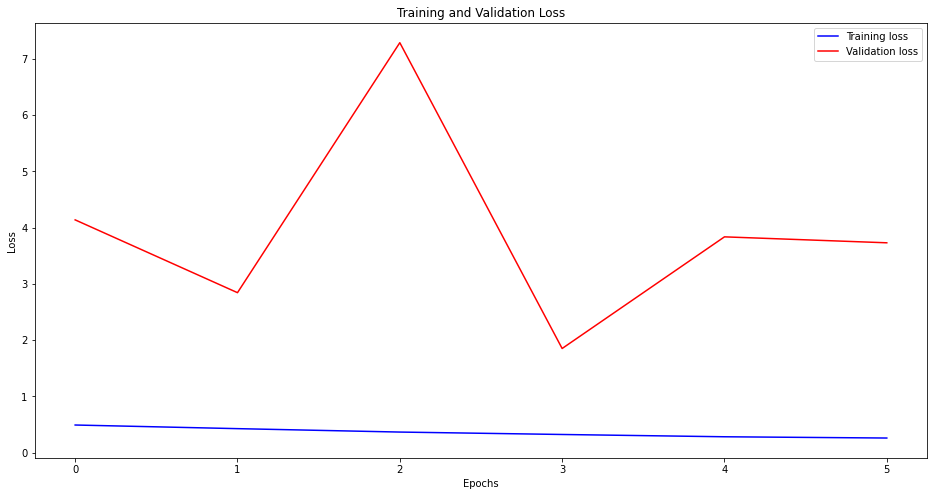

In [69]:
def visualize_loss(history: keras.callbacks.History, title: str) -> plt.figure:
    """
    Visualizing the training and validation loss
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))

    plt.figure(figsize=(16,8))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Prediction

The trained model above is now able to make predictions for 5 sets of values from
validation set.

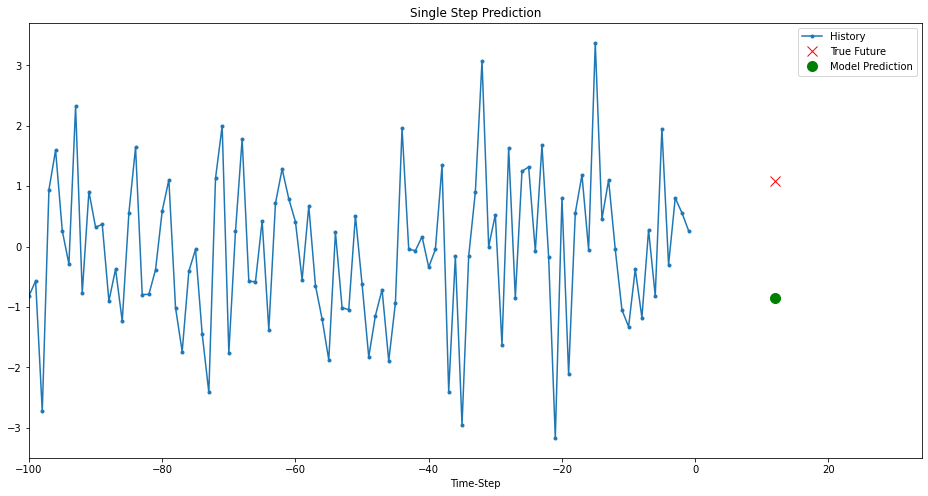

In [70]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.figure(figsize=(16,8))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )